## Molecular Property Prediction

Molecular property prediction plays a crucial role in computer-aided drug discovery (CADD) by enabling the estimation of key characteristics such as solubility, permeability, and bioavailability without extensive experimental efforts. These predictions help prioritize compounds for synthesis and testing, saving time and resources while improving the efficiency of the drug development pipeline.

This project focuses on predicting **aqueous solubility (LogS)** of small drug-like molecules using **Machine Learning (ML)** models trained on experimental data and molecular descriptors. 

#### Tools used:
- **RDKit**: A cheminformatics library for handling chemical information and generating molecular descriptors.
- **Mordred**: A Python library for calculating thousands of molecular descriptors from chemical structures.
- **Statsmodels**: Used for Multiple Linear Regression (MLR) to establish baseline models and analyze feature relationships.
- **Scikit-learn**: Provides machine learning models such as Random Forest Regression (RF) for non-linear solubility prediction.
- **SHAP (SHapley Additive exPlanations)**: Enhances model interpretability by explaining feature contributions to predictions.

#### Objectives of this Project:
- Develop predictive models for LogS using experimental solubility data and computed molecular descriptors.
- Compare multiple regression models, including MLR and RF, to evaluate predictive performance and feature importance.
- Interpret model predictions using statistical coefficients and SHAP values to understand key molecular features influencing solubility.
- Visualize feature importance through bar charts, SHAP summary plots, and coefficient plots, providing insights into descriptor contributions.

In [1]:
%pip install requests
%pip install pandas
%pip install mordred
%pip install statsmodels
%pip install scikit-learn
%pip install shap
%pip install ipywidgets

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.


### Aqueous solubility (LogS)

Aqueous solubility (LogS) is a critical molecular property in drug discovery as it directly impacts a compound's absorption, distribution, and overall bioavailability. Poor solubility is a major reason why many promising drug candidates fail during development.

The experimental LogS values for this project were sourced from:

[**Rytting, E., Lentz, K.A., Chen, XQ. et al. Aqueous and cosolvent solubility data for drug-like organic compounds. AAPS J 7, 10 (2005)**](https://doi.org/10.1208/aapsj070110)
  
This dataset provides high-quality solubility data which were carefully selected under following criteria:

- Drug or drug-like compounds which are solid at room temperature
- Solubility values of unionized species (intrinsic solubility) at or around 25°C
- Solubility measurement: equilibrium achieved over time; excess solid present at the end of testing; and acceptable analytical methods used for detection.

In [ ]:
import pandas as pd

df = pd.read_csv('logS_dataset.csv', sep=';') 
df.head(5)  

,Name,logS
0,"1,2,3-Trichlorobenzene",–3.76
1,"1,3,5-Trichlorobenzene",–4.44
2,"1,4-Dibromobenzene",–4.07
3,17Alpha-ethynylestradiol,–4.484
4,1-Butyltheobromine,–1.625


### Retrieving Canonical SMILES from PubChem

Canonical SMILES for the compounds in the dataset were retrieved using the PubChem PUG REST API. According to PubChem's usage policies:
- The request rate must be limited to **five requests per second** or fewer to avoid being temporarily blocked from accessing PubChem (or NCBI) resources.
- Each request has a standard time limit of **30 seconds**, after which a time-out error will occur if the request is not completed.

To comply with these policies, requests were processed in a controlled manner with a delay between queries.

In [ ]:
import requests
import time

prolog = 'https://pubchem.ncbi.nlm.nih.gov/rest/pug'
name_list = df['Name'].values.tolist()

smiles = []

def get_smiles(start, end): # start and end index of a batch
    
    smiles_batch = []
    idx = 0
    for name in name_list[start:end]: # loop over each element in the batch 

        url = prolog + '/compound/name/' + name + '/property/CanonicalSMILES/txt'
        res = requests.get(url)

        if res.status_code == 200:
            smiles_batch += list(set(res.text.split())) # Use a set to remove duplicates (w/ different CIDs)
        else:
            smiles_batch.append('None')
        
        if idx % 5 == 4: # to limit the request rate to five requests per second
            time.sleep(0.2)
        idx += 1
    
    return smiles_batch

In [5]:
num_batch = len(name_list) // 50 # Batch size of 50 compounds

for i in range(num_batch): # loop over each batch in the 'name_list' list
    start = i*50
    end = (i+1)*50
    smiles += get_smiles(start, end)
    print(f'Compounds {start+1} - {end} Done!')
    time.sleep(1)

last_batch_start = 50*num_batch
last_batch_end = 50*num_batch + len(name_list)%50
smiles += get_smiles(last_batch_start, last_batch_end)
print(f'Compounds {last_batch_start+1} - {last_batch_end} Done!')

print(len(smiles))

Compounds 1 - 50 Done!
Compounds 51 - 100 Done!
Compounds 101 - 150 Done!
Compounds 151 - 200 Done!
Compounds 201 - 250 Done!
Compounds 251 - 300 Done!
Compounds 301 - 322 Done!
322


The retrieved Canonical SMILES were added as a new column to the dataset. 

In [6]:
df['Canonical_SMILES'] = smiles
df

,Name,logS,Canonical_SMILES
0,"1,2,3-Trichlorobenzene",–3.76,C1=CC(=C(C(=C1)Cl)Cl)Cl
1,"1,3,5-Trichlorobenzene",–4.44,C1=C(C=C(C=C1Cl)Cl)Cl
2,"1,4-Dibromobenzene",–4.07,C1=CC(=CC=C1Br)Br
3,17Alpha-ethynylestradiol,–4.484,CC12CCC3C(C1CCC2(C#C)O)CCC4=C3C=CC(=C4)O
4,1-Butyltheobromine,–1.625,CCCCN1C(=O)C2=C(N=CN2C)N(C1=O)C
...,...,...,...
317,Uric acid,–3.402,C12=C(NC(=O)N1)NC(=O)NC2=O
318,Vinbarbital,–2.458,CCC=C(C)C1(C(=O)NC(=O)NC1=O)CC
319,Xanthine,–2.483,C1=NC2=C(N1)C(=O)NC(=O)N2
320,Zidovudine,–1.029,CC1=CN(C(=O)NC1=O)C2CC(C(O2)CO)N=[N+]=[N-]


### Data Cleaning: Handling Missing and Invalid Values

Several compounds were not found in the PubChem queries. These missing Canonical SMILES were manually searched and added to the dataset. After updating the dataset with the manually collected SMILES, the dataframe was checked for any remaining missing values. 

In [7]:
indices = [i for i, val in enumerate(smiles) if val == 'None']

name_not_found = []
for i in indices:
    name_not_found.append(df['Name'].iloc[i])

print(len(indices))
print(name_not_found)

30
['1-Propyltheobromine', '2-Aminopteridine', '2-Hydroxypteridine', '5,5-Diethylbarbiturate', '5,5-Dimethylbarbiturate', '5,5-Diphenylbarbiturate', '5,5-Dipropylbarbiturate', '5-Allyl-5-phenylbarbiturate', '5-Ethyl-5-(3-methylbut-2-enyl)barbiturate', '5-Ethyl-5-allylbarbiturate', '5-Ethyl-5-nonylbarbiturate', '5-Ethyl-5-octylbarbiturate', '5-Ethyl-5-pentylbarbiturate', '5-Ethyl-5-propylbarbiturate', '5-Ethyl-barbiturate', '5-i-Propyl-5-(3-methylbut-2enyl)barbiturate', '5-Methyl barbiturate', '5-Methyl-5-(3-methylbut-2enyl)barbiturate', '5-Methyl-5-ethylbarbiturate', '5-t-Butyl-5-(3-methylbut-2enyl)barbiturate', 'Cyclobutane-spirobarbiturate', 'Cycloethane-spirobarbiturate', 'Cycloheptane-spirobarbiturate', 'Cyclohexane-spirobarbiturate', 'Cyclopentane-spirobarbiturate', 'Cyclopropane-spirobarbiturate', 'Isopropylbarbiturate', 'Pteridine-2-methyl-thiol', 'Pteridine-4-methyl-thiol', 'Pteridine-7-methyl-thiol']


In [8]:
smiles_missing = {'1-Propyltheobromine': 'CCCN1C(=O)C2=C(N=CN2C)N(C1=O)C',
                  '2-Aminopteridine': 'N=1C=CN=C2C=NC(=NC12)N',
                  '2-Hydroxypteridine': 'O=C1N=CN=C2NC=CN=C12',
                  '5,5-Diethylbarbiturate': 'O=C1NC(=O)C(C(=O)N1)(CC)CC',
                  '5,5-Dimethylbarbiturate': 'O=C1NC(=O)C(C(=O)N1)(C)C',
                  '5,5-Diphenylbarbiturate': 'O=C1NC(=O)C(C=2C=CC=CC2)(C=3C=CC=CC3)C(=O)N1',
                  '5,5-Dipropylbarbiturate': 'O=C1NC(=O)C(C(=O)N1)(CCC)CCC',
                  '5-Allyl-5-phenylbarbiturate': 'O=C1NC(=O)C(C(=O)N1)(C=2C=CC=CC2)CC=C',
                  '5-Ethyl-5-(3-methylbut-2-enyl)barbiturate': 'O=C1NC(=O)C(C=CC(C)C)(C(=O)N1)CC',
                  '5-Ethyl-5-allylbarbiturate': 'O=C1NC(=O)C(C(=O)N1)(CC=C)CC',
                  '5-Ethyl-5-nonylbarbiturate': 'O=C1NC(=O)C(C(=O)N1)(CC)CCCCCCCCC',
                  '5-Ethyl-5-octylbarbiturate': 'O=C1NC(=O)C(C(=O)N1)(CC)CCCCCCCC',
                  '5-Ethyl-5-pentylbarbiturate': 'O=C1NC(=O)C(C(=O)N1)(CC)CCCCC',
                  '5-Ethyl-5-propylbarbiturate': 'O=C1NC(=O)C(C(=O)N1)(CC)CCC',
                  '5-Ethyl-barbiturate': 'O=C1NC(=O)C(C(=O)N1)CC',
                  '5-i-Propyl-5-(3-methylbut-2enyl)barbiturate': 'O=C1NC(=O)C(C=CC(C)C)(C(=O)N1)C(C)C',
                  '5-Methyl barbiturate': 'O=C1NC(=O)C(C(=O)N1)C',
                  '5-Methyl-5-(3-methylbut-2enyl)barbiturate': 'O=C1NC(=O)C(C=CC(C)C)(C(=O)N1)C',
                  '5-Methyl-5-ethylbarbiturate': 'O=C1NC(=O)C(C(=O)N1)(C)CC',
                  '5-t-Butyl-5-(3-methylbut-2enyl)barbiturate': 'O=C1N(C(=O)C(C=CC(C)C)(C(=O)N1)C(C)(C)C)',
                  'Cyclobutane-spirobarbiturate': 'O=C1NC(=O)C2(C(=O)N1)CCCC2',
                  'Cycloethane-spirobarbiturate': 'O=C1NC(=O)C2(C(=O)N1)CC2',
                  'Cycloheptane-spirobarbiturate': 'O=C1NC(=O)C2(C(=O)N1)CCCCCCC2',
                  'Cyclohexane-spirobarbiturate': 'O=C1NC(=O)C2(C(=O)N1)CCCCCC2',
                  'Cyclopentane-spirobarbiturate': 'O=C1NC(=O)C2(C(=O)N1)CCCCC2',
                  'Cyclopropane-spirobarbiturate': 'O=C1NC(=O)C2(C(=O)N1)CCC2',
                  'Isopropylbarbiturate': 'O=C1NC(=O)C(C(=O)N1)C(C)C',
                  'Pteridine-2-methyl-thiol': 'N=1C=CN=C2C=NC(=NC12)SC',
                  'Pteridine-4-methyl-thiol': 'N=1C=NC(SC)=C2N=CC=NC12',
                  'Pteridine-7-methyl-thiol': 'N=1C=NC=2N=C(SC)C=NC2C1'
                  }

In [9]:
for name, smiles in smiles_missing.items():
    df.loc[(df["Name"] == name) & (df["Canonical_SMILES"] == "None"), "Canonical_SMILES"] = smiles

print(df[df['Canonical_SMILES'] == 'None']) # Check if there are still missing SMILES

Empty DataFrame
Columns: [Name, logS, Canonical_SMILES]
Index: []


During the processing of Canonical SMILES, some compounds had invalid SMILES strings, which caused errors during molecule generation in RDKit (e.g., explicit valence errors). To ensure the integrity of the dataset, compounds with invalid SMILES were identified and dropped from the dataframe. 


In [75]:
from rdkit import Chem

invalid_indices = [i for i, val in enumerate(df["Canonical_SMILES"]) if Chem.MolFromSmiles(val) == None]

print(invalid_indices)

[8, 45, 51]


[17:45:59] Explicit valence for atom # 8 Cl, 3, is greater than permitted
[17:45:59] Explicit valence for atom # 8 Cl, 3, is greater than permitted
[17:45:59] Explicit valence for atom # 7 Cl, 3, is greater than permitted


In [76]:
df_updated = df.drop(df.index[invalid_indices])
still_invalid = [i for i, val in enumerate(df_updated["Canonical_SMILES"]) if Chem.MolFromSmiles(val) == None]

print(still_invalid)

[]


The logS values were initially stored as strings, which needed to be converted to floats for numerical analysis and modeling. Also, the negative signs of logS values were written with en dashes (–) instead of hyphens (-), which can cause issues during processing. These were replaced with standard hyphens to ensure compatibility with cheminformatics tools.

In [77]:
df = df_updated
df['logS'] = df['logS'].str.replace('–', '-').astype(float)

The final updated dataframe, now complete with Canonical SMILES, is saved as a CSV file for further use in the project.

In [78]:
df.to_csv('logS_dataset_updated.csv', index=False)

In [3]:
df = pd.read_csv('logS_dataset_updated.csv', sep=',') 

### Calculation and Filtering of Mordred descriptorss

Mordred descriptors were calculated for all molecules in the dataset using their Canonical SMILES. 3D descriptors were disregarded to increase the prediction speed and avoid redundancy problems.

In [5]:
from mordred import Calculator, descriptors
from rdkit import Chem

smiles_list = df['Canonical_SMILES']

calc = Calculator(descriptors, ignore_3D=True)  # 2D descriptors only
molecules = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]
desc_df = calc.pandas(molecules)

print(desc_df)

                                                   ABC  \
0    module 'numpy' has no attribute 'float'.\n`np....   
1    module 'numpy' has no attribute 'float'.\n`np....   
2    module 'numpy' has no attribute 'float'.\n`np....   
3    module 'numpy' has no attribute 'float'.\n`np....   
4    module 'numpy' has no attribute 'float'.\n`np....   
..                                                 ...   
314  module 'numpy' has no attribute 'float'.\n`np....   
315  module 'numpy' has no attribute 'float'.\n`np....   
316  module 'numpy' has no attribute 'float'.\n`np....   
317  module 'numpy' has no attribute 'float'.\n`np....   
318  module 'numpy' has no attribute 'float'.\n`np....   

                                                 ABCGG  nAcid  nBase  \
0    module 'numpy' has no attribute 'float'.\n`np....      0      0   
1    module 'numpy' has no attribute 'float'.\n`np....      0      0   
2    module 'numpy' has no attribute 'float'.\n`np....      0      0   
3    module 'nu

In [6]:
desc_df.to_csv('desc_df.csv', index=False)

Only numerical descriptors are retained, as categorical variables (e.g., molecule names) are not useful for regression models.

In [7]:
desc_num = desc_df.select_dtypes(include='number')
desc_num.shape

(319, 1221)

Features with very little variation across the dataset do not provide much distinguishing power for predicting solubility. For example, if a descriptor has nearly the same value for all molecules, it is unlikely to be useful in the model. Therefore, descriptors with little variation across molecules (variance ≤ 0.1) were removed from the dataset.

In [9]:
from sklearn.feature_selection import VarianceThreshold

vt = VarianceThreshold(threshold=0.1)
vt.fit(desc_num)
mask = vt.get_support()
desc_vt = desc_num.loc[:, mask]

desc_vt.shape

(319, 725)

Some molecular descriptors may carry redundant information, i.e. they are highly correlated with one another. Including multiple highly correlated features in a regression model can cause **multicollinearity**, which reduces model stability and interpretability. For this reason, descriptors that are highly correlated (|r| > 0.8) were eliminated from the dataset.

In [ ]:
corr_features = set()
corr_matrix = desc_vt.corr()

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            colname = corr_matrix.columns[i]
            corr_features.add(colname)

len(corr_features)

558

In [ ]:
desc_reduced = desc_vt.drop(labels=corr_features, axis=1, inplace=True)

desc_reduced.shape

C:\Users\chp11\AppData\Local\Temp\ipykernel_16124\3422776969.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  desc_reduced.drop(labels=corr_features, axis=1, inplace=True)


(319, 167)

The descriptor **"FilterItLogS"** was explicitly removed from the dataset to ensure that the model remains independent and does not rely on precomputed solubility values from another ML model (FilterIt).

In [14]:
desc_reduced.drop('FilterItLogS', axis=1, inplace=True)

desc_reduced.shape

C:\Users\chp11\AppData\Local\Temp\ipykernel_16124\4222013278.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  desc_reduced.drop('FilterItLogS', axis=1, inplace=True)


(319, 166)

In [15]:
desc_reduced.head()

,nAcid,nBase,SpAbs_A,VR1_A,nAromAtom,nBridgehead,nHetero,nN,nO,nS,...,nAHRing,n5AHRing,nFRing,n9FRing,n10FRing,nG12FRing,nFHRing,nFaRing,nFARing,nFAHRing
0,0,0,10.891331,26.623093,6,0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,10.128990,26.528645,6,0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,9.924777,22.227825,6,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,28.895827,172.520252,6,0,2,0,2,0,...,0,0,1,0,0,1,0,0,1,0
4,0,0,21.323572,128.527091,9,0,6,4,2,0,...,0,0,1,1,0,0,1,1,0,0


The final version of the reduced dataframe of calculated descriptors was saved as a CSV file for later use.

In [16]:
desc_reduced.to_csv('desc_reduced.csv', index=False)

In [51]:
desc_reduced = pd.read_csv('desc_reduced.csv', sep=',') 

### ML Models for logS Prediction

To develop predictive models for LogS, the dataset was randomly split into **80% training** and **20% test** sets to evaluate model performance on unseen data. The training set is used to fit the models, while the test set assesses their generalization ability.

In [52]:
from sklearn.model_selection import train_test_split

X = desc_reduced
y = df['logS']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

Before fitting the dataset to the ML models, a function was created to generate scatter plots illustrating the relationship between experimental and predicted LogS values while also summarizing model performance using various metrics, including R-squared (R²), Root Mean Squared Error (RMSE), and Mean Absolute Error (MAE).

In [3]:
from sklearn.metrics import r2_score as r2, root_mean_squared_error as rmse, mean_absolute_error as mae
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def model_eval(reg):
    y_pred_train, y_pred_test = reg.predict(X_train), reg.predict(X_test)

    plt.figure(figsize=(7,3))

    # Plot 1: Training Dataset
    plt.subplot(1, 2, 1)
    plt.scatter(x=y_train, y=y_pred_train, c="#7CAE00", alpha=1)

    z = np.polyfit(y_train, y_pred_train, 1)
    p = np.poly1d(z)
    plt.plot(y_test, p(y_test), "#F8766D")

    plt.title("Training Dataset", fontsize=11)
    plt.xlabel('Experimental LogS', fontsize=10)
    plt.ylabel('Predicted LogS', fontsize=10)

    # Plot 2: Test Dataset
    plt.subplot(1, 2, 2)
    plt.scatter(x=y_test, y=y_pred_test, c="#619CFF", alpha=1)

    z = np.polyfit(y_test, y_pred_test, 1)
    p = np.poly1d(z)
    plt.plot(y_test, p(y_test), "#F8766D")

    plt.title("Test Dataset", fontsize=11)
    plt.ylabel('Predicted LogS', fontsize=10)
    plt.xlabel('Experimental LogS', fontsize=10)

    plt.tight_layout()
    plt.show()

    # Model Evaluation: R², RMSE and MAE
    metrics = {
        "Dataset": ["Training", "Test"],
        "R²": [r2(y_train, y_pred_train), r2(y_test, y_pred_test)],
        "RMSE": [rmse(y_train, y_pred_train), rmse(y_test, y_pred_test)],
        "MAE": [mae(y_train, y_pred_train), mae(y_test, y_pred_test)]
    }
    
    return pd.DataFrame(metrics).round(4)

**Multiple Linear Regression (MLR) model** was trained using the training dataset, and LogS values were predicted using this model. The scatter plot for the training dataset (left) shows a strong correlation between experimental and predicted LogS values, with data points closely aligned with the diagonal line (y = x). This is confirmed by the high R² (0.9447) and low error metrics, indicating that the model fits the training data well.

The model was then used to predict LogS values for the test dataset, where performance dropped significantly (R² = -0.9741). A negative R² indicates that the model performs worse than simply predicting the mean of the target variable. The high RMSE and MAE suggest large prediction errors, which are also evident from the scattered data points in the scatter plot for the test dataset (right).

This stark contrast between training and test performance suggests that the model is **overfitting**—it has learned patterns too specific to the training data and does not generalize well to new data.

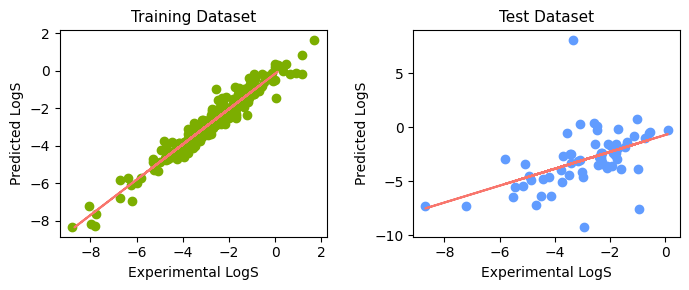

,Dataset,R²,RMSE,MAE
0,Training,0.9447,0.3959,0.2893
1,Test,-0.9741,2.2722,1.3638


In [ ]:
from sklearn import linear_model

linear_reg = linear_model.LinearRegression()
linear_reg.fit(X_train, y_train)
model_eval(linear_reg)

The same process was applied using the **Random Forest (RF) regression model**. In terms of the training dataset, the RF model outperforms the MLR model, achieving an R² of 0.9450. When evaluated on the test dataset, the RF model demonstrated significantly better generalization compared to the MLR model. However, the test dataset's R² of 0.6858 indicates that the model's performance is still suboptimal. The substantial difference between the training and test R² values suggests that RF model is also overfitting.

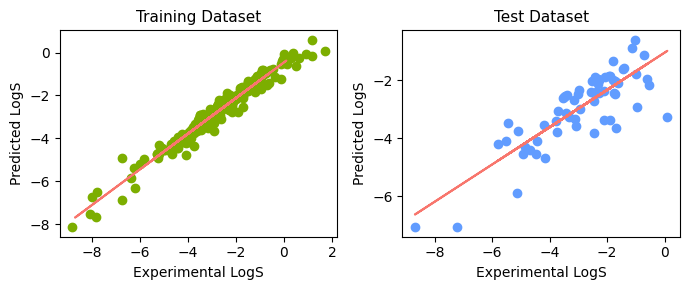

,Dataset,R²,RMSE,MAE
0,Training,0.9450,0.3949,0.2746
1,Test,0.6858,0.9065,0.6518


In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train, y_train)
model_eval(rf_reg)

To address the overfitting, **Variance Inflation Factor (VIF)** analysis was applied to reduce multicollinearity among descriptors. Since the number of descriptors (166) was relatively large compared to the dataset size (319), this step was taken to retain only independent features that contribute uniquely to the model. 

VIF values were calculated for all descriptors, and features with the highest VIF were iteratively removed until all remaining features had a VIF below the threshold of 10. As a result, the number of descriptors was reduced from 166 to 77, significantly lowering redundancy in the feature set. This reduction is expected to enhance model generalization by minimizing multicollinearity.

In [21]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data["Descriptor"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_data

desc_vif = desc_reduced.copy()

# Iteratively remove features with high VIF
threshold = 10  
while True:
    vif_df = calculate_vif(desc_vif)
    max_vif = vif_df["VIF"].max()
    
    if max_vif < threshold:  
        break
    
    remove_col = vif_df.loc[vif_df["VIF"] == max_vif, "Descriptor"].values[0]
    print(f"Removing: {remove_col} (VIF={max_vif:.2f})")
    
    desc_vif = desc_vif.drop(columns=[remove_col])

print(f"\nFinal feature set contains {desc_vif.shape[1]} descriptors:")
print(desc_vif.columns.tolist())

c:\Users\chp11\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Removing: n5Ring (VIF=inf)


c:\Users\chp11\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Removing: nFRing (VIF=inf)
Removing: AATS0se (VIF=332181.38)
Removing: nHetero (VIF=199880.80)
Removing: nAromAtom (VIF=29968.11)
Removing: AATS0d (VIF=24027.61)
Removing: SpAbs_A (VIF=19851.67)
Removing: AATS0i (VIF=15418.18)
Removing: nHBDon (VIF=7598.03)
Removing: BCUTi-1h (VIF=5948.79)
Removing: AATS0v (VIF=5266.28)
Removing: AATS0dv (VIF=4131.52)
Removing: StsC (VIF=3478.26)
Removing: nO (VIF=3226.84)
Removing: AATSC0dv (VIF=2797.22)
Removing: nN (VIF=2501.95)
Removing: C2SP2 (VIF=2162.66)
Removing: BCUTd-1h (VIF=1859.85)
Removing: IC1 (VIF=1305.37)
Removing: ATSC1dv (VIF=1215.12)
Removing: nHRing (VIF=1105.10)
Removing: BCUTdv-1h (VIF=954.55)
Removing: AATSC0i (VIF=915.49)
Removing: AATS1Z (VIF=796.64)
Removing: nBondsD (VIF=717.46)
Removing: SlogP_VSA2 (VIF=672.89)
Removing: BalabanJ (VIF=647.87)
Removing: ATS0Z (VIF=433.58)
Removing: VSA_EState1 (VIF=427.33)
Removing: AATSC0v (VIF=391.07)
Removing: NsCH3 (VIF=366.74)
Removing: ETA_dBeta (VIF=302.81)
Removing: PEOE_VSA1 (VIF=257

In [22]:
desc_vif.to_csv('desc_vif.csv', index=False)

In [53]:
desc_vif = pd.read_csv('desc_vif.csv', sep=',') 

In [54]:
X_vif = desc_vif
y = df['logS']

X_train, X_test, y_train, y_test = train_test_split(X_vif, y, test_size=0.2,random_state=42)

After applying VIF-based feature selection, noticeable changes were observed in the performance of both the MLR and RF models.

For the MLR model, the training R² dropped from 0.9450 to 0.8069, while the test R² improved significantly to 0.5343, indicating better generalization. However, despite this improvement, the test performance remained relatively poor, with RMSE (1.1036) and MAE (0.8400) still indicating substantial prediction errors. This suggests that while reducing multicollinearity improved generalization, linear regression may still struggle with capturing the underlying complexity of the data.

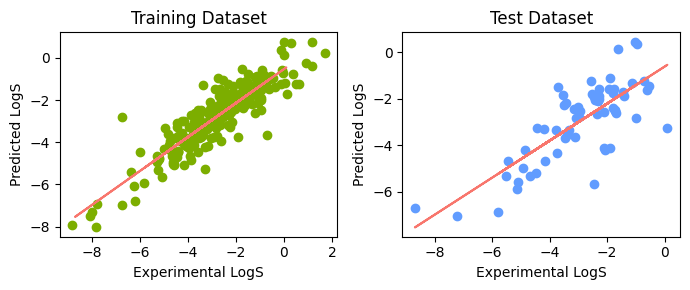

,Dataset,R²,RMSE,MAE
0,Training,0.8069,0.7401,0.5317
1,Test,0.5343,1.1036,0.8400


In [55]:
linear_reg_vif = linear_model.LinearRegression()
linear_reg_vif.fit(X_train, y_train)
model_eval(linear_reg_vif)

In contrast to MLR, the RF model did not exhibit severe overfitting before VIF. After VIF, however, the test R² dropped to 0.5513, and both RMSE and MAE increased, i.e. the model’s predictive performance worsened. This suggests that random forests benefit from having a larger set of features and that some removed descriptors contained useful information that helped the model make better predictions. Unlike MLR, RF can handle multicollinearity well, so reducing correlated features may have inadvertently removed valuable signals from the dataset.

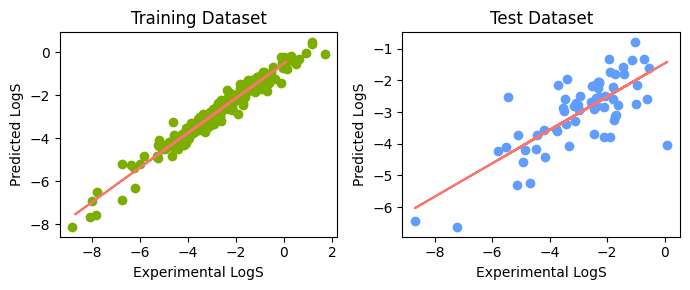

,Dataset,R²,RMSE,MAE
0,Training,0.9347,0.4305,0.3064
1,Test,0.5513,1.0833,0.7748


In [56]:
rf_reg_vif = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg_vif.fit(X_train, y_train)
model_eval(rf_reg_vif)

The above ML model analyses demonstrate that a sufficiently large dataset is crucial for building reliable ML models, especially when a high number of features are involved. To improve the predictive performance and reduce overfitting, a larger dataset from another source was added to the original dataset. The new dataset was obtained from: 

[**Tayyebi, A., Alshami, A.S., Rabiei, Z. et al. Prediction of organic compound aqueous solubility using machine learning: a comparison study of descriptor-based and fingerprints-based models. J Cheminform 15, 99 (2023).**](https://doi.org/10.1186/s13321-023-00752-6) 

By expanding the dataset, the model was expected to generalize better and produce more robust predictions.

In [45]:
df2 = pd.read_csv('logS_dataset2.csv', sep=',') 

When merging the datasets, the absolute difference in LogS values was calculated for compounds present in both datasets. If this difference was equal to or greater than 0.1, the compound was removed from the dataset to ensure consistency in the experimental data. The final dataset contained 8750 compounds in total.

In [46]:
df_filtered = df[~df["Canonical_SMILES"].isin(df2["Canonical_SMILES"])]
df_new = pd.concat([df2, df_filtered[["Canonical_SMILES", "logS"]]], ignore_index=True)

df_new.shape

(8753, 2)

In [47]:
df_merged = df.merge(df2, on="Canonical_SMILES", suffixes=('_df', '_df_new'))
df_merged["logS_difference"] = df_merged["logS_df"] - df_merged["logS_df_new"]

df_merged[["Canonical_SMILES", "logS_df", "logS_df_new", "logS_difference"]]

,Canonical_SMILES,logS_df,logS_df_new,logS_difference
0,COC1=NC2=CN=CN=C2N=C1,-1.139,-1.025,-0.114
1,CN(C)C1=NC2=NC=NC=C2N=C1,-0.021,-0.020,-0.001
2,CCN(CC)C(=S)SSC(=S)N(CC)CC,-2.995,-4.860,1.865
3,CCC(CO)NCCNC(CC)CO,-0.565,0.550,-1.115


In [48]:
to_remove = df_merged.loc[abs(df_merged["logS_difference"]) >= 0.1, "Canonical_SMILES"]
df_new = df_new[~df_new["Canonical_SMILES"].isin(to_remove)]

df_new.shape

(8750, 2)

In [49]:
df_new.to_csv('logS_dataset_new.csv', index=False)

In [4]:
df_new = pd.read_csv('logS_dataset_new.csv', sep=',') 

In [ ]:
smiles_list = df_new['Canonical_SMILES']

calc = Calculator(descriptors, ignore_3D=True)  
molecules = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]
desc_df2 = calc.pandas(molecules)

desc_df2.shape

(8750, 1613)

In [ ]:
desc_df2.to_csv('desc_df2.csv', index=False)

In [ ]:
desc_df2 = pd.read_csv('desc_df2.csv', sep=',') 

Following dataset expansion, Mordred descriptors were recalculated for all compounds in the combined dataset, and the same preprocessing steps were applied as earlier.

In [ ]:
# Remove categorical variables
desc_new = desc_df2.select_dtypes(include='number')

# Remove features with low variance
vt = VarianceThreshold(threshold=0.1)
vt.fit(desc_new)
mask = vt.get_support()
desc_new.loc[:, mask]

# Remove highly correlated features
corr_features = set()
corr_matrix = desc_new.corr()

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            colname = corr_matrix.columns[i]
            corr_features.add(colname)

desc_corr = desc_new.drop(labels=corr_features, axis=1, inplace=True)

# Remove FilterItLogS descriptor
desc_new.drop('FilterItLogS', axis=1, inplace=True)

desc_new.shape

(8750, 348)

In [69]:
desc_new.to_csv('desc_new.csv', index=False)

In [5]:
desc_new = pd.read_csv('desc_new.csv', sep=',') 

In [8]:
from sklearn.model_selection import train_test_split

X = desc_new
y = df_new['logS']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

After training the MLR model on the expanded dataset, the performance significantly improved compared to the model trained on the smaller dataset. The training set achieved an R²of 0.8142, while the test set reached an R² of 0.7833, indicating a better generalization ability. However, upon examining the scatter plot for the test set, a single data point was found to be significantly distant from all others. This point was identified as an outlier and subsequently removed.

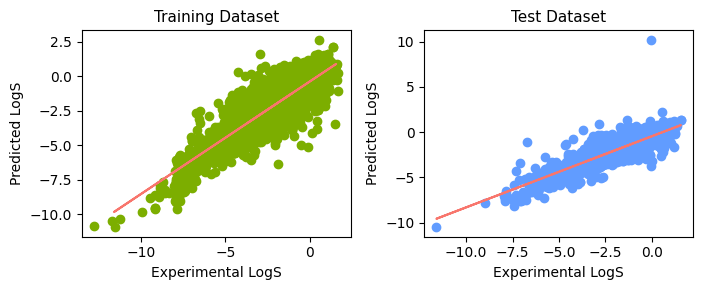

,Dataset,R²,RMSE,MAE
0,Training,0.8142,0.8052,0.6059
1,Test,0.7650,0.8731,0.6386


In [9]:
linear_reg = linear_model.LinearRegression()
linear_reg.fit(X_train, y_train)
model_eval(linear_reg)

The outlier detection was based on residual analysis, where residuals exceeding ten times the standard deviation were considered outliers.

In [10]:
y_pred_test = linear_reg.predict(X_test)  
residuals = np.abs(y_test - y_pred_test)

threshold = 10 * np.std(residuals)
outlier_indices = np.where(residuals > threshold)[0]

print(outlier_indices)

[103]


In [11]:
X_test_filtered = np.delete(X_test, outlier_indices, axis=0)
X_test = pd.DataFrame(X_test_filtered, columns=X_train.columns)
y_test = np.delete(y_test, outlier_indices, axis=0)

After eliminating the outlier, the test set performance improved slightly, but the overall gain was minor. Regardless, the expanded dataset led to a much better model performance compared to the model trained on the smaller dataset.

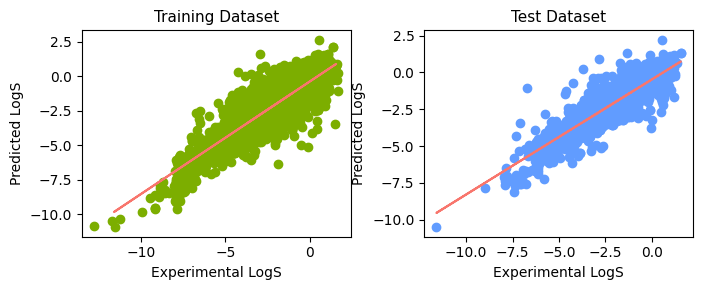

,Dataset,R²,RMSE,MAE
0,Training,0.8142,0.8052,0.6059
1,Test,0.7833,0.8384,0.6332


In [12]:
linear_reg = linear_model.LinearRegression()
linear_reg.fit(X_train, y_train)
model_eval(linear_reg)

The RF model also showed substantial improvement with the larger dataset. The training set achieved an R² of 0.9815, while the test set performance reached an R² of 0.8784. The reduction in RMSE and MAE indicated a more accurate prediction capability. Compared to MLR, the RF model demonstrated superior performance, as reflected in the scatter plot, where the data points were more tightly clustered around the diagonal line. This suggests that RF captured the underlying patterns in the data more effectively than MLR.

In conclusion, the RF model proved to be better suited for LogS prediction based on molecular descriptors. While MLR improved with the larger dataset, its predictive capability remained lower than RF. The superior performance of RF suggests that it is more capable of handling complex relationships between molecular descriptors and solubility, making it the preferred model for this task.

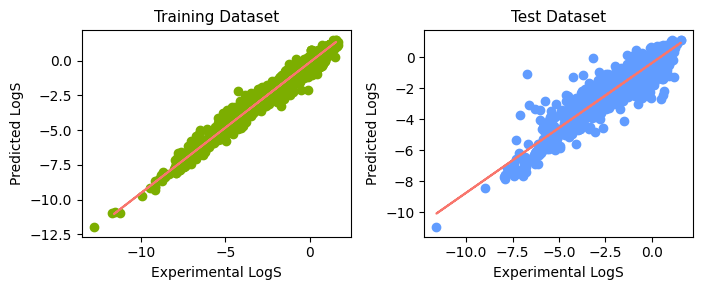

,Dataset,R²,RMSE,MAE
0,Training,0.9815,0.2543,0.1659
1,Test,0.8784,0.6279,0.4053


In [13]:
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train, y_train)
model_eval(rf_reg)

### Feature Importance Plots for LogS Prediction Models

**MLR Coefficient Bar Plot** visualizes the top ten most influential features in the MLR model, based on their coefficients. The presence of both positive and negative coefficients indicates whether a feature contributes positively or negatively to the predicted logS values. Features with large absolute coefficients have a greater impact on the predictions, while those with near-zero coefficients contribute less significantly.

- Features like Xch-3d have a strong positive influence, meaning an increase in this descriptor leads to an increase in predicted logS values.
- Conversely, features like nI have large negative coefficients, suggesting they negatively correlate with solubility.
- The presence of both large positive and negative coefficients suggests that the model is attempting to fit the data using linear relationships, but may struggle with non-linearity in feature interactions.

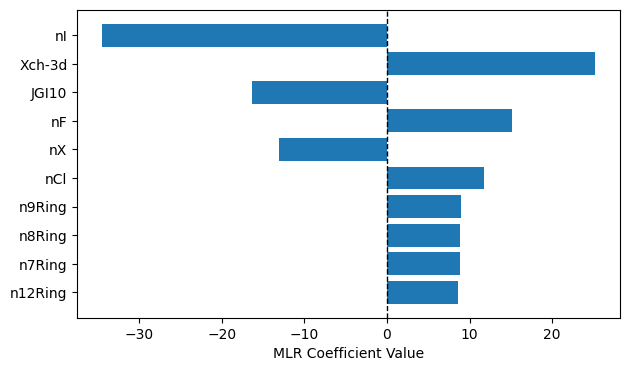

In [77]:
feature_names = X_train.columns
coefficients = linear_reg.coef_

sorted_indices = np.argsort(np.abs(coefficients))[::-1][:10]  # Top 10 features
top_features = feature_names[sorted_indices]
top_coefficients = coefficients[sorted_indices]

plt.figure(figsize=(7, 4))
plt.barh(top_features[::-1], top_coefficients[::-1])  
plt.xlabel("MLR Coefficient Value")
plt.axvline(0, color='black', linestyle='--', linewidth=1)  
plt.show()

**SHAP (SHapley Additive exPlanations)** is a powerful interpretability method used to explain the predictions of machine learning models. It is based on game theory, where each feature in a model is treated as a "player" that contributes to the final prediction. SHAP values quantify how much each feature contributes—positively or negatively—to an individual prediction, providing insight into the model’s decision-making process.

In [14]:
import shap

explainer = shap.Explainer(rf_reg)
shap_values = explainer(X_test)

**Mean SHAP Value Bar Plot** illustrates the average impact of each feature on the RF model's predictions. Unlike MLR, which assigns a fixed coefficient to each feature, SHAP values account for non-linear interactions between features.

- PEOE_VSA6 and ECIndex are the most influential descriptors, contributing significantly to the model’s predictions.
- Compared to MLR, RF considers more complex interactions between features, leading to a different ranking of important descriptors.
- Features with higher SHAP values exert a greater influence on predicted logS values, making them key descriptors for understanding solubility trends.

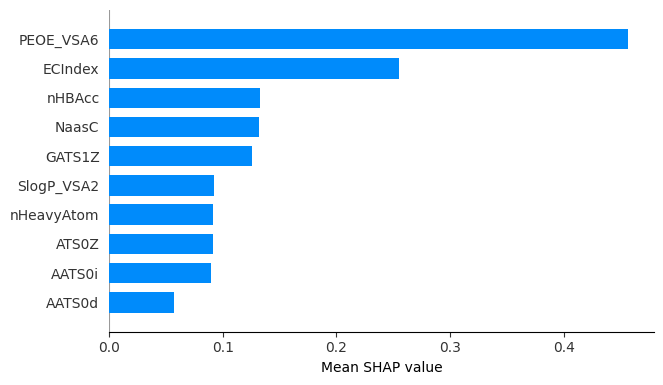

In [74]:
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False, max_display=10, plot_size=[7,4])

fig, ax = plt.gcf(), plt.gca()
ax.set_xlabel('Mean SHAP value', fontdict={"size":10})
ax.tick_params(labelsize=10)

**SHAP Value Scatter Plot** provides a more detailed view of how each descriptor affects individual predictions. Features are ranked based on their importance, and the color gradient represents feature values (high in red, low in blue).

- Features like PEOE_VSA6 show a wide spread of SHAP values, indicating that their impact varies significantly across different data points.
- A positive SHAP value suggests that a high feature value increases the predicted logS, while a negative SHAP value indicates a decrease in logS.
- The distribution of SHAP values across different feature values highlights the complex, non-linear dependencies captured by the RF model, which MLR cannot model effectively.

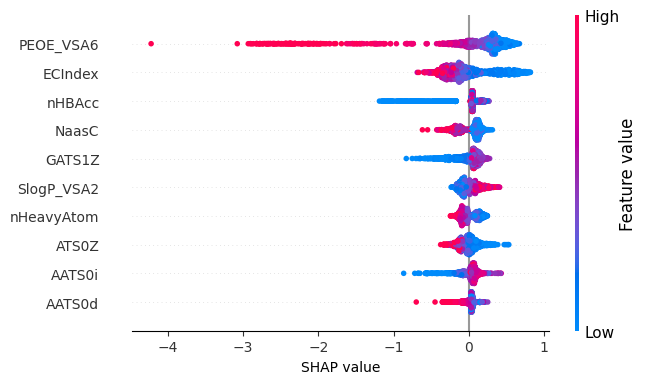

In [ ]:
shap.summary_plot(shap_values, plot_type="dot", show=False, max_display=10, plot_size=[7,4])

fig, ax = plt.gcf(), plt.gca()
ax.set_xlabel('SHAP value', fontdict={"size":10})
ax.tick_params(labelsize=10)

**Comparison of MLR and RF Models**

- The MLR model assigns fixed coefficients to each feature, making it easier to interpret but limiting its ability to model complex interactions.
- The RF model provides more flexibility by capturing non-linear relationships, as demonstrated by the variation in SHAP values.
- The SHAP-based analysis shows that RF is more robust in handling feature dependencies, resulting in higher predictive performance compared to MLR.